In this script is the data smoothen after the PC are constructed 

In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
dset = open_s3fs('PC-data')
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [7]:
# rewriting the name of the variables 
vvar = dset.vomecrty
uvar = dset.vozocrtx
uv = dset.vel

In [8]:
# Getting the bottom velocity 
d = dset.mbathy.values-1
d[d==-1] = 0

d = xr.DataArray(d, dims=['y','x'])

uvar_b = uvar.isel(depth=d)
vvar_b = vvar.isel(depth=d)
uv_b = uv.isel(depth=d)

Making 7 plots from different depths

In [9]:
# funcktion for rolling mean 
def running_mean(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N%2 == 0:
            a, b = i - (N-1)//2, i + (N-1)//2 + 2
        else:
            a, b = i - (N-1)//2, i + (N-1)//2 + 1

        #cap indices to min and max indices
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out

In [10]:
uv_b

<xarray.DataArray 'vel' (y: 1801, x: 1580)>
dask.array<reshape, shape=(1801, 1580), dtype=float32, chunksize=(1801, 1580), chunktype=numpy.ndarray>
Coordinates:
    depth          (y, x) float64 0.5058 0.5058 0.5058 ... 0.5058 0.5058 0.5058
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: y, x

In [10]:
warnings.filterwarnings('ignore')
    
dx = 20
dy = 20
# Making empty list with size as data-points 
jmax, imax = uv[0].shape #fetches the max value in j and i direction 
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

# Making the covmatrix and finding the eigenvalues and eigenvectors
# list of all the points for the PC-crosses
'Dont remember how I got to this number, so dont know how to change the number of points in each PC'
PC11 = np.zeros(3379)
PC12 = np.zeros(3379)
PC21 = np.zeros(3379)
PC22 = np.zeros(3379)
y = np.zeros(3379)
x = np.zeros(3379)
indx = 0
    
# to get the loop to run faster
uvy = np.array(uv_b.y.values)
uvx = np.array(uv_b.x.values)
    
# fetching the varaibel at the given level 
uvar_depth = np.array(uvar_b.values)
vvar_depth = np.array(vvar_b.values)
uv_depth = np.array(uv_b.values)
    
for i in i_list:
    for j in j_list:
        covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
        [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            values, vectors = np.linalg.eig(covm)
            PC11[int(indx)] = vectors[0,0]*np.sqrt(values[0])
            PC12[int(indx)] = vectors[1,0]*np.sqrt(values[0])
            PC21[int(indx)] = vectors[0,1]*np.sqrt(values[1])
            PC22[int(indx)] = vectors[1,1]*np.sqrt(values[1])
            y[int(indx)] = uvy[j]
            x[int(indx)] = uvx[i]
            indx = indx + 1
                
# converting to np.arrays
PC11 = np.array(PC11,dtype=float)
PC12 = np.array(PC12,dtype=float)
PC21 = np.array(PC21,dtype=float)
PC22 = np.array(PC22,dtype=float)
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)
    
# smoothening the data
PC11 = running_mean(PC11, 10)
PC12 = running_mean(PC12, 10)
PC21 = running_mean(PC21, 10)
PC22 = running_mean(PC22, 10)


Level 1

In [19]:
cmap = plt.get_cmap('magma_r')


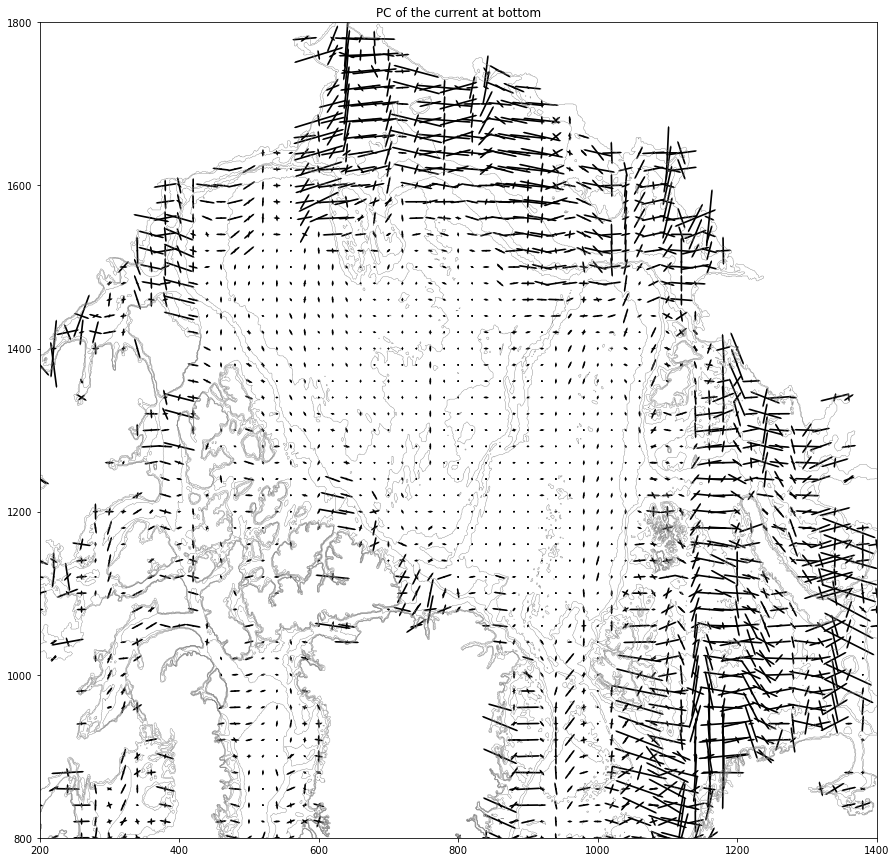

In [22]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at bottom')
ax.contour(dset.mbathy, colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::1], y[::1], PC11[::1], PC12[::1], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver(x[::1], y[::1], -PC11[::1], -PC12[::1],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::1], y[::1], PC21[::1], PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::1], y[::1], -PC21[::1], -PC22[::1],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.set_xlim(200,1400)
ax.set_ylim(800,1800)

plt.show()

level 2